In [2]:
from pathlib import Path
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import sympy
import os, shutil

In [ ]:
# Paths for SDPA-GMP execution and I/O directories
home = Path.home()
sdpa_exec = home / "sdpa-gmp" / "sdpa_gmp"
inputs = home / "sdpa-notebooks" / "inputs"
outputs = home / "sdpa-notebooks" / "outputs"
param_file_path = home / "sdpa-notebooks" / "param.sdpa"

In [ ]:
def clear_folders():
    """
    Remove all files and subdirectories inside the input and output folders.
    """

    # Iterate over folders to be cleared
    for folder in [inputs, outputs]:
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)

            # Delete files or symbolic links
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)

            # Delete subdirectories recursively
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)

In [ ]:
def moment_symbols_list_generator(num_of_elements):
    """
    Generate a symbolic moment list using the recurrence relation.

    Parameters
    ----------
    num_of_elements : int
        Total number of symbolic moments to generate.

    Returns
    -------
    list
        List of symbolic moment expressions.
    """

    E = sympy.symbols("E")   # Energy symbol
    moment_symbols = [1]     # Initial moment x_0

    for i in range(1, num_of_elements):
        if i < 8:
            # For low indices, insert zeros for odd i and x_i for even i
            if i % 2 != 0:
                moment_symbols.append(0)
            else:
                moment_symbols.append(sympy.symbols(f"x_{i}"))
        else:
            # Apply recurrence for higher-order symbolic moments
            moment_symbols.append(0)
            moment_symbols[i] += 4 * (i - 7) * E * moment_symbols[i - 8]
            moment_symbols[i] += (i - 7) * (i - 8) * (i - 9) * moment_symbols[i - 10]
            moment_symbols[i] -= 2 * (i - 6) * moment_symbols[i - 6]
            moment_symbols[i] += 4 * (i - 5) * moment_symbols[i - 4]
            moment_symbols[i] /= (i - 3) / 2

    return moment_symbols


In [ ]:
def extract_coeff_matrix(matrix, var):
    """
    Extract the coefficient of a given variable from each entry of a symbolic matrix.

    Parameters
    ----------
    matrix : sympy.Matrix
        Matrix whose entries are symbolic expressions.
    var : sympy.Symbol
        Variable whose coefficient is to be extracted.

    Returns
    -------
    sympy.Matrix
        Matrix where each entry is coeff(entry, var).
    """

    # Apply coeff(var) to each entry of the matrix
    return matrix.applyfunc(lambda expr: expr.coeff(var))


In [ ]:
def extract_coeff_matrix_with_fixed_Energy(E_value, M, vars_to_extract, K):
    """
    Substitute E = E_value into matrix M and extract coefficient matrices
    for each variable in vars_to_extract, along with the constant matrix.

    Parameters
    ----------
    E_value : float
        Numerical value to substitute for the symbol E.
    M : sympy.Matrix
        Symbolic matrix whose entries may depend on E and other variables.
    vars_to_extract : list
        List of sympy symbols whose coefficients should be extracted.
    K : int
        Dimension of the (K x K) matrices to process.

    Returns
    -------
    coeff_matrices : dict
        Maps each variable : its extracted K * K coefficient matrix (as list of lists).
    const_matrix : list
        Constant K * K matrix after removing all variable-dependent terms.
    """

    E = sympy.symbols("E")
    M_fixed = M.subs(E, E_value)        # Replace E with given value

    # Initialize output matrices
    coeff_matrices = {var: sympy.Matrix.zeros(K, K) for var in vars_to_extract}
    const_matrix = sympy.Matrix.zeros(K, K)

    # Extract coefficients entry-by-entry
    for i in range(K):
        for j in range(K):
            expr = M_fixed[i, j]
            remaining = expr

            # Subtract off contributions from each variable
            for var in vars_to_extract:
                coeff = expr.coeff(var)
                coeff_matrices[var][i, j] = coeff.evalf()
                remaining -= coeff * var

            const_matrix[i, j] = remaining

    # Convert matrices to plain lists
    for var in vars_to_extract:
        coeff_matrices[var] = coeff_matrices[var].tolist()

    const_matrix = const_matrix.tolist()

    return coeff_matrices, const_matrix


In [ ]:
def extract_obj_val(result, file_path):
    """
    Extract the primal objective value ('objValPrimal') from an SDPA output file.

    Parameters
    ----------
    result : CompletedProcess
        The subprocess result returned by running SDPA.
    file_path : str
        Path to the SDPA output file to read.

    Returns
    -------
    float
        The extracted primal objective value.

    Raises
    ------
    ValueError
        If 'objValPrimal' is not found in the file.
    """

    # Look for the line containing 'objValPrimal'
    with open(file_path, 'r') as f:
        for line in f:
            if 'objValPrimal' in line:
                # Extract the numeric value at the end of the line
                return float(line.strip().split()[-1])

    # If not found, print solver output for debugging
    print(result.stdout)
    raise ValueError("objValPrimal not found in output file.")

In [ ]:
# Parameter ranges
K_list = [15, 20, 25]
energy_list = list(np.arange(0, 7, 0.01))
t_val_dict = {}

clear_folders()   # Reset SDPA input/output directories

for K in K_list:
    t_val_list = []

    for energy in energy_list:
        # Generate symbolic moments and free variables
        moment_symbols_list = moment_symbols_list_generator(2 * K + 1)
        free_vars = [moment_symbols_list[2], moment_symbols_list[4], moment_symbols_list[6]]

        # Build symbolic Hankel matrix
        symbols_Hankel_matrix = sympy.Matrix(
            K, K, lambda i, j: moment_symbols_list[i + j]
        )

        # Extract coefficient matrices after fixing energy
        coeff_matrices, const_matrix = extract_coeff_matrix_with_fixed_Energy(
            energy, symbols_Hankel_matrix, free_vars, K
        )

        # Build SDPA input header
        input_content = f"{len(free_vars) + 1}"
        input_content += "\n1"
        input_content += f"\n{K}"
        input_content += "\n-1" + " 0" * len(free_vars)

        # Add constant part of Hankel matrix
        for i in range(K):
            for j in range(i, K):
                if const_matrix[i][j] != 0:
                    input_content += (
                        f"\n0 1 {i + 1} {j + 1} {-const_matrix[i][j]}"
                    )

        # Add identity constraint
        for i in range(K):
            input_content += f"\n1 1 {i + 1} {i + 1} -1"

        # Add variable-dependent blocks
        var_no = 2
        for var in free_vars:
            for i in range(K):
                for j in range(i, K):
                    if coeff_matrices[var][i][j] != 0:
                        input_content += (
                            f"\n{var_no} 1 {i + 1} {j + 1} {coeff_matrices[var][i][j]}"
                        )
            var_no += 1

        # File paths
        input_file = str(inputs) + f"/data_{K}_{energy}.dat-s"
        output_file = str(outputs) + f"/result_{K}_{energy}.out"

        # Write SDPA input file
        Path(input_file).write_text(input_content)

        # Run SDPA-GMP
        result = subprocess.run(
            [str(sdpa_exec), str(input_file), str(output_file)],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            check=True
        )

        # Extract primal value and store log10(|t|)
        primal_val = extract_obj_val(result, output_file)
        t_val_list.append(np.log10(np.abs(primal_val)))

    # Store values for this K
    t_val_dict[K] = t_val_list


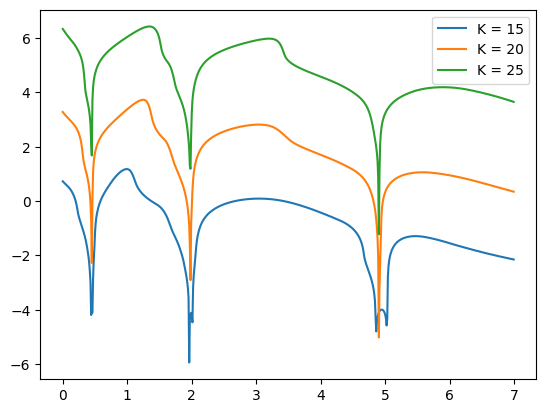

In [ ]:
# Plot t-values vs energy for all K
for K in K_list:
    plt.plot(energy_list, t_val_dict[K], label=f"K = {K}")

plt.legend()

In [ ]:
def extract_coeff_matrix_with_fixed_Energy_and_moment(E_value, moment_value, moment_symbols_list,
                                                      moment_no, M, vars_to_extract, K):
    """
    Substitute E = E_value and a specific moment = moment_value into M,
    then extract coefficient matrices for each variable in vars_to_extract,
    along with the remaining constant matrix.

    Parameters
    ----------
    E_value : float
        Numerical value to substitute for the symbol E.
    moment_value : float
        Numerical value to substitute for moment_symbols_list[moment_no].
    moment_symbols_list : list
        List of symbolic moments used inside M.
    moment_no : int
        Index of the moment symbol being fixed.
    M : sympy.Matrix
        Symbolic matrix whose entries depend on E and selected moments.
    vars_to_extract : list
        Variables whose coefficients should be extracted.
    K : int
        Dimension of the matrix.

    Returns
    -------
    coeff_matrices : dict
        Mapping var → K×K coefficient matrix (as lists).
    const_matrix : list
        K×K constant matrix after removing variable-dependent terms.
    """

    E = sympy.symbols("E")

    # Substitute E and the chosen moment value
    M_fixed = M.subs([(E, E_value), (moment_symbols_list[moment_no], moment_value)])

    # Initialize coefficient and constant matrices
    coeff_matrices = {var: sympy.Matrix.zeros(K, K) for var in vars_to_extract}
    const_matrix = sympy.Matrix.zeros(K, K)

    # Extract coefficients entry-by-entry
    for i in range(K):
        for j in range(K):
            expr = M_fixed[i, j]
            remaining = expr

            # Subtract var contributions
            for var in vars_to_extract:
                coeff = expr.coeff(var)
                coeff_matrices[var][i, j] = coeff
                remaining -= coeff * var

            const_matrix[i, j] = remaining

    # Convert matrices to plain lists
    for var in vars_to_extract:
        coeff_matrices[var] = coeff_matrices[var].tolist()

    const_matrix = const_matrix.tolist()

    return coeff_matrices, const_matrix


In [ ]:
# Parameter grids
K_list = [12, 13, 14, 15, 16]
energy_list = list(np.arange(0.3, 0.7, 0.005))
moment_list = list(np.arange(0.5, 0.8, 0.005))

t_val_dict = {}

for K in K_list:
    clear_folders()          # Reset input/output directory
    print(K)
    t_val_list = []

    for moment in moment_list:
        temp = []            # Values for this fixed moment

        for energy in energy_list:
            # Generate symbolic moments and choose free variables
            moment_symbols_list = moment_symbols_list_generator(2 * K + 1)
            free_vars = [moment_symbols_list[4], moment_symbols_list[6]]

            # Build symbolic Hankel matrix
            symbols_Hankel_matrix = sympy.Matrix(
                K, K, lambda i, j: moment_symbols_list[i + j]
            )

            # Extract constant and variable coefficient matrices
            coeff_matrices, const_matrix = extract_coeff_matrix_with_fixed_Energy_and_moment(
                energy, moment, moment_symbols_list, 2,
                symbols_Hankel_matrix, free_vars, K
            )

            # SDPA input: header
            input_content = f"{len(free_vars) + 1}"
            input_content += "\n1"
            input_content += f"\n{K}"
            input_content += "\n-1" + " 0" * len(free_vars)

            # Constant Hankel block
            for i in range(K):
                for j in range(i, K):
                    if const_matrix[i][j] != 0:
                        input_content += (
                            f"\n0 1 {i + 1} {j + 1} {-const_matrix[i][j]}"
                        )

            # Identity constraint
            for i in range(K):
                input_content += f"\n1 1 {i + 1} {i + 1} -1"

            # Variable-dependent blocks
            var_no = 2
            for var in free_vars:
                for i in range(K):
                    for j in range(i, K):
                        if coeff_matrices[var][i][j] != 0:
                            input_content += (
                                f"\n{var_no} 1 {i + 1} {j + 1} {coeff_matrices[var][i][j]}"
                            )
                var_no += 1

            # File paths
            input_file = str(inputs) + f"/data_{K}_{energy}_{moment}.dat-s"
            output_file = str(outputs) + f"/result_{K}_{energy}_{moment}.out"

            # Write SDPA input file
            Path(input_file).write_text(input_content)

            # Run SDPA-GMP
            result = subprocess.run(
                [str(sdpa_exec), str(input_file), str(output_file)],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                text=True,
                check=True
            )

            # Extract primal objective
            primal_val = extract_obj_val(result, output_file)
            temp.append(np.log10(np.abs(primal_val)))

        # Add row for this moment
        t_val_list.append(temp)

    # Store all results for this K
    t_val_dict[K] = t_val_list


12
13
14
15
16


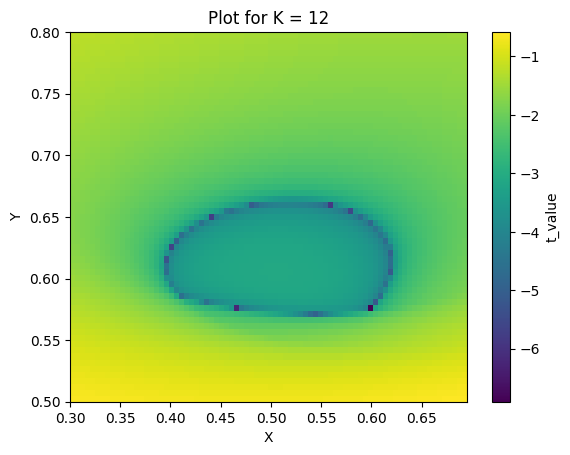

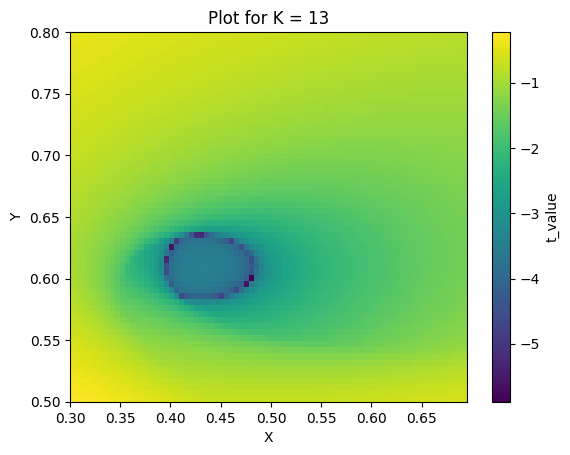

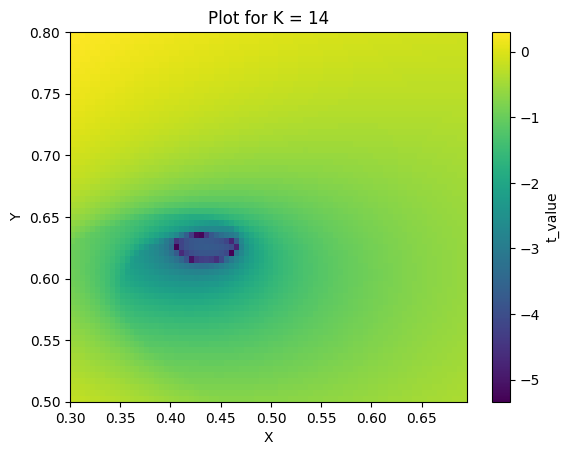

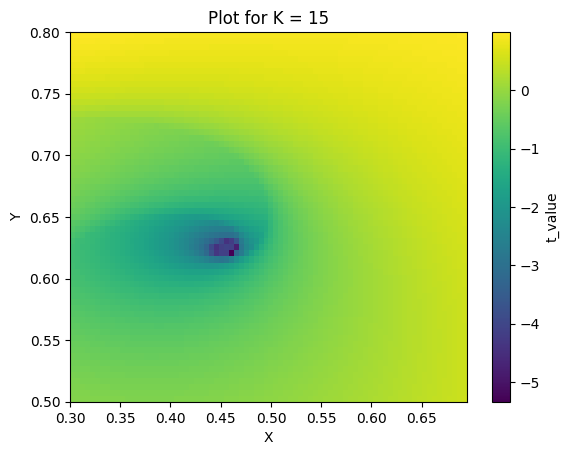

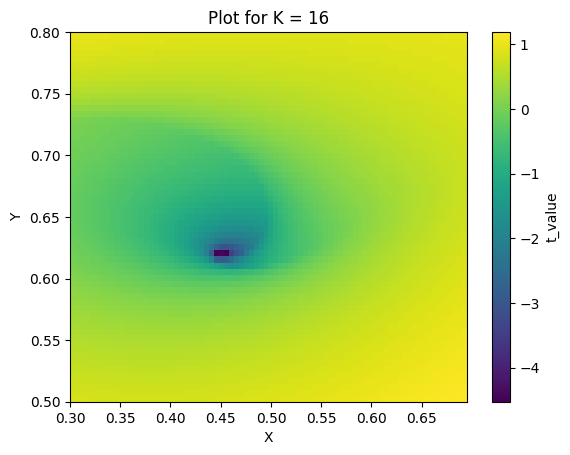

In [ ]:
for K in K_list:
    plt.figure()

    # Heatmap of t-values across (energy, moment)
    plt.imshow(
        t_val_dict[K],
        extent=[min(energy_list), max(energy_list),
                min(moment_list), max(moment_list)],
        origin='lower',
        cmap='viridis',
        aspect='auto'
    )

    plt.colorbar(label='t_value')
    plt.title(f"Plot for K = {K}")

    # Axis labels
    plt.xlabel("X")
    plt.ylabel("Y")

    plt.show()


In [ ]:
# Parameter ranges
K_list = [12, 13, 14, 15, 16]
energy_list = list(np.arange(0.3, 0.7, 0.005))
t_val_dict = {}

clear_folders()   # Reset SDPA input/output folders

for K in K_list:
    t_val_list = []

    for energy in energy_list:
        # Build symbolic moments and choose free variables
        moment_symbols_list = moment_symbols_list_generator(2 * K + 1)
        free_vars = [moment_symbols_list[2], moment_symbols_list[4], moment_symbols_list[6]]

        # Construct symbolic Hankel matrix
        symbols_Hankel_matrix = sympy.Matrix(
            K, K, lambda i, j: moment_symbols_list[i + j]
        )

        # Extract coefficient matrices after fixing the energy value
        coeff_matrices, const_matrix = extract_coeff_matrix_with_fixed_Energy(
            energy, symbols_Hankel_matrix, free_vars, K
        )

        # SDPA input header
        input_content = f"{len(free_vars) + 1}"
        input_content += "\n1"
        input_content += f"\n{K}"
        input_content += "\n-1" + " 0" * len(free_vars)

        # Constant Hankel part
        for i in range(K):
            for j in range(i, K):
                if const_matrix[i][j] != 0:
                    input_content += f"\n0 1 {i + 1} {j + 1} {-const_matrix[i][j]}"

        # Add identity constraint
        for i in range(K):
            input_content += f"\n1 1 {i + 1} {i + 1} -1"

        # Variable-dependent blocks
        var_no = 2
        for var in free_vars:
            for i in range(K):
                for j in range(i, K):
                    if coeff_matrices[var][i][j] != 0:
                        input_content += (
                            f"\n{var_no} 1 {i + 1} {j + 1} {coeff_matrices[var][i][j]}"
                        )
            var_no += 1

        # Build file paths
        input_file = str(inputs) + f"/data_{K}_{energy}.dat-s"
        output_file = str(outputs) + f"/result_{K}_{energy}.out"

        # Write SDPA input file
        Path(input_file).write_text(input_content)

        # Run SDPA-GMP
        result = subprocess.run(
            [str(sdpa_exec), str(input_file), str(output_file)],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            check=True
        )

        # Extract primal objective value
        primal_val = extract_obj_val(result, output_file)
        t_val_list.append(np.log10(np.abs(primal_val)))

    # Store values for this K
    t_val_dict[K] = t_val_list


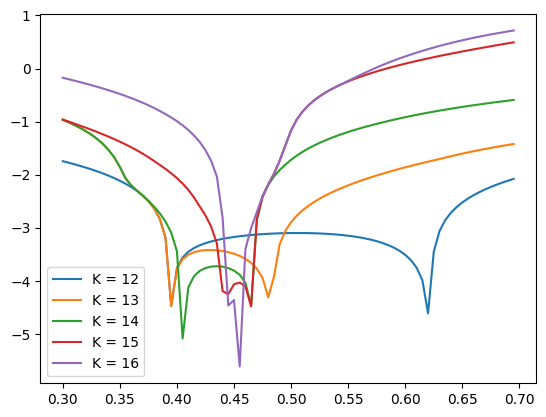

In [ ]:
# Plot t-values vs energy for each K
for K in K_list:
    plt.plot(energy_list, t_val_dict[K], label=f"K = {K}")

plt.legend()
